In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import torch

from mlflux.predictor import FluxANNs
from mlflux.eval import open_case, evaluate, eval_bias, plot_pred, plot_res, plot_corr

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

%load_ext autoreload
%autoreload 3

## Plot prediction 

### Against one independent variables - different random seeds

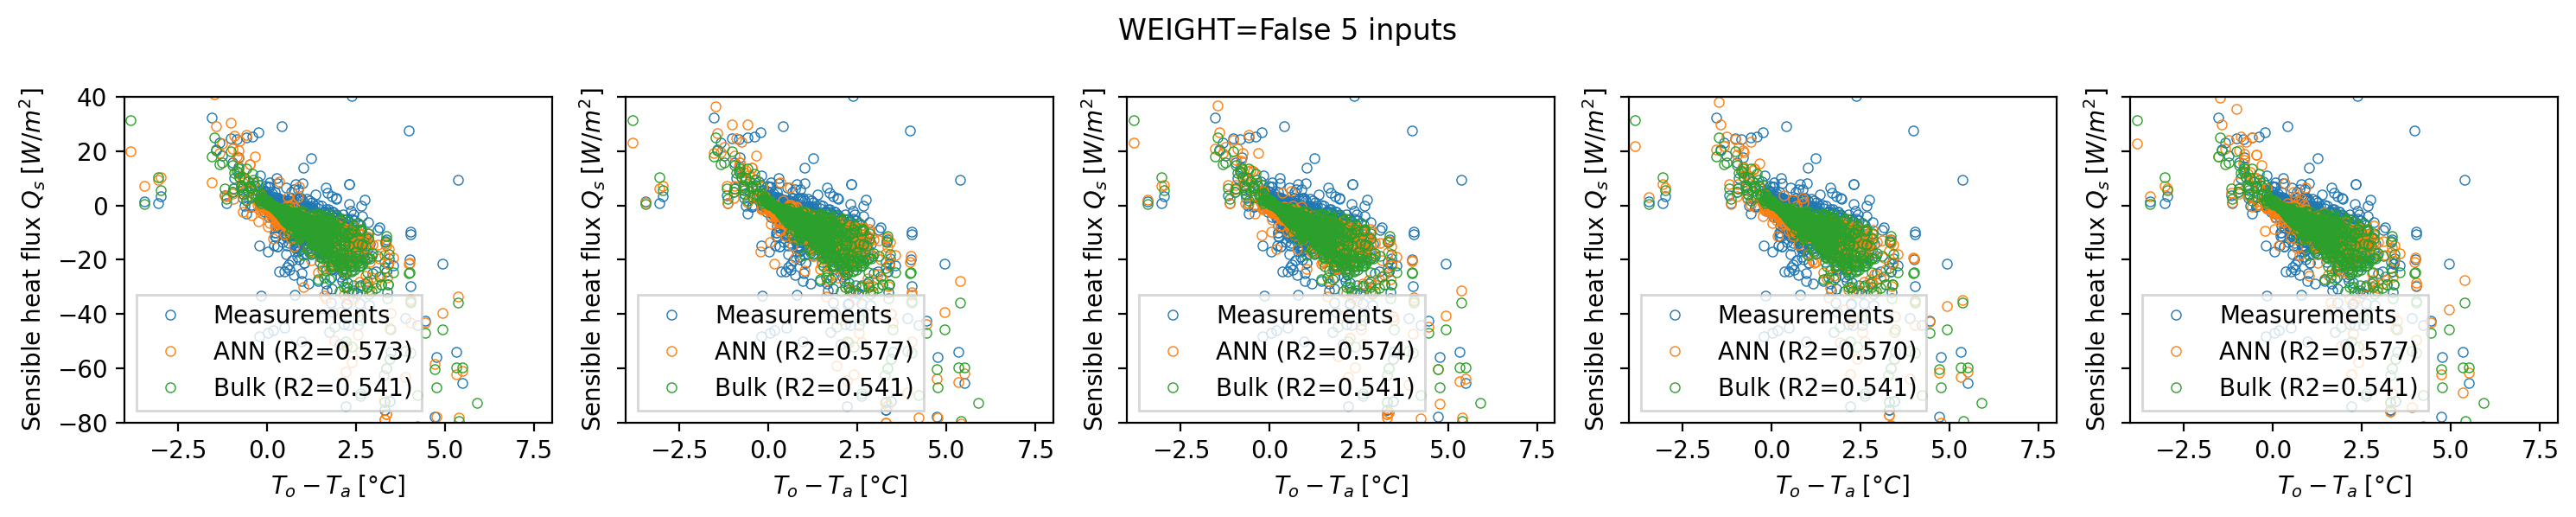

In [8]:
# model_dir = f'/home/jw8736/mlflux/saved_model/final/SH8_1/NW_tr2/'  
# model_dir = f'/home/jw8736/mlflux/saved_model/final/SH4_1/tr2/'
# model_dir = f'/home/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'

###### Used ones
# model_dir = f'/home/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'
model_dir = f'/home/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
# model_dir = f'/home/jw8736/mlflux/saved_model/final/SH4_1/NW_tr2/'
# model_dir = f'/home/jw8736/mlflux/saved_model/final/M4_1/NW_tr2/'

###### If we want to use other versions of bulk formula
import re
USE3p6 = False # Seems like 3p0 has higher R2 than 3p6 in LH and SH ~ 0.3%, but momentum is up by 1.5%

fig, axes = plt.subplots(1, 5, figsize=[15,3], dpi=200, sharey=True)
for rand_seed in range(5):
    model_name = 'model_rand%g.p' %rand_seed
    model = open_case (model_dir, model_name)
    ax = axes[rand_seed]
    datafile = model.config['datapath'] + model.config['datafile']
    if USE3p6:
        datafile = re.sub(r'psd_coare3p0', 'psd_coare3p6', datafile)
    ds = xr.load_dataset(datafile)
    plot_pred (ax, model, ds, subsample=1000)

fig.suptitle(f'WEIGHT=' + str(model.config['WEIGHT']) + ' %g inputs' %len(model.config['ikeys']))
plt.tight_layout()

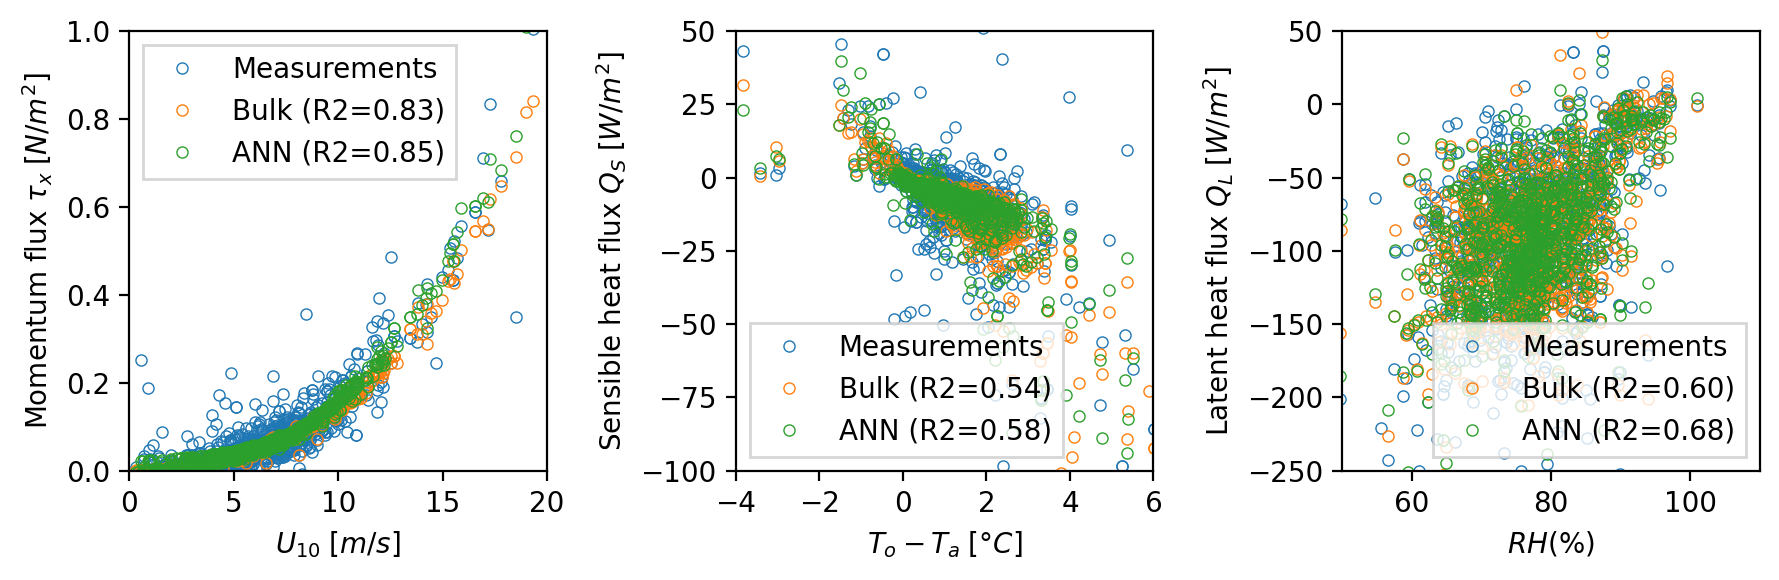

In [26]:
###### Used ones
LH_dir = f'/scratch/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'
SH_dir = f'/scratch/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
M_dir  = f'/scratch/jw8736/mlflux/saved_model/final/M5_1/NW_tr2/'
rand_seed = 4 # choose the one random seed where loss curves look good

fig, axes = plt.subplots(1, 3, figsize=[9,3], dpi=200)

ax = axes[0]; dir = M_dir
model = open_case (dir, 'model_rand%g.p' %rand_seed)
datafile = model.config['datapath'] + model.config['datafile']
ds = xr.load_dataset(datafile)
plot_pred (ax, model, ds, subsample=1000)

ax = axes[1]; dir = SH_dir
model = open_case (dir, 'model_rand%g.p' %rand_seed)
plot_pred (ax, model, ds, subsample=1000)

ax = axes[2]; dir = LH_dir
model = open_case (dir, 'model_rand%g.p' %rand_seed)
plot_pred (ax, model, ds, subsample=1000)

# fig.suptitle(f'WEIGHT=' + str(model.config['WEIGHT']) + ' %g inputs' %len(model.config['ikeys']))
plt.tight_layout()
plt.savefig(f'../../plots/predictions_1input.png', bbox_inches='tight')

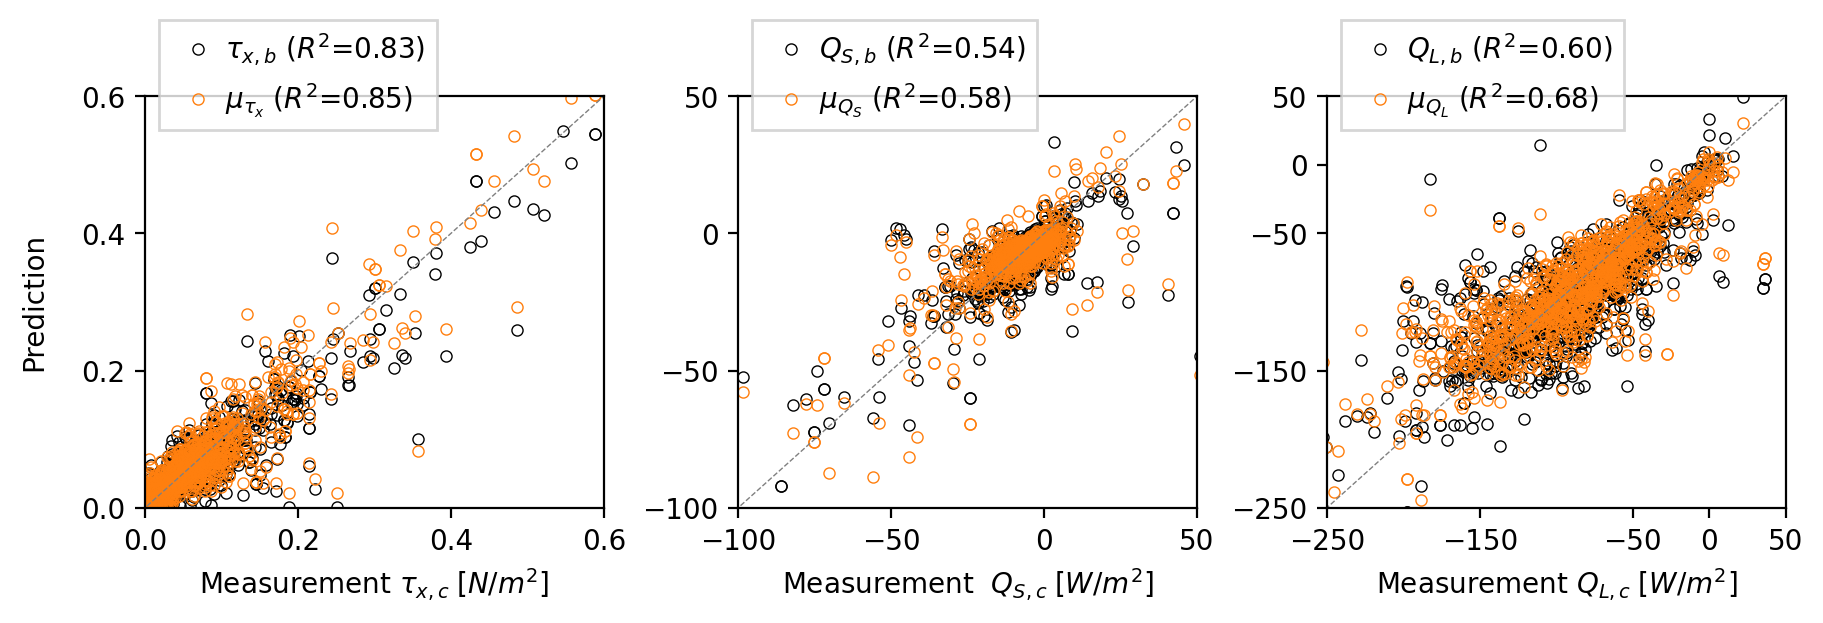

In [2]:
###### Used ones
LH_dir = f'/scratch/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'
SH_dir = f'/scratch/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
M_dir  = f'/scratch/jw8736/mlflux/saved_model/final/M5_1/NW_tr2/'
rand_seed = 4 # choose the one random seed where loss curves look good

fig, axes = plt.subplots(1, 3, figsize=[9,3], dpi=200, constrained_layout=True)

ax = axes[0]; dir = M_dir
model = open_case (dir, 'model_rand%g.p' %rand_seed)
datafile = model.config['datapath'] + model.config['datafile']
ds = xr.load_dataset(datafile)
plot_corr (ax, model, ds, subsample=1000)

ax = axes[1]; dir = SH_dir
model = open_case (dir, 'model_rand%g.p' %rand_seed)
plot_corr (ax, model, ds, subsample=1000)

ax = axes[2]; dir = LH_dir
model = open_case (dir, 'model_rand%g.p' %rand_seed)
plot_corr (ax, model, ds, subsample=1000)

# fig.suptitle(f'WEIGHT=' + str(model.config['WEIGHT']) + ' %g inputs' %len(model.config['ikeys']))
# plt.tight_layout()
axes[0].set_ylabel('Prediction', labelpad=12)
plt.savefig(f'../../plots/predictions_corr.pdf', bbox_inches='tight')

In [4]:
from mlflux.datafunc import data_split_psd
split2 = [[77, 69, 87, 83, 68, 73, 71], [67, 72, 78], [67, 72, 78]] # calwater, hiwings, neaqs
training_ds, validating_ds, testing_ds = data_split_psd(ds, split=split2, 
                                                        PLOT=False, XVIS='samples', VERBOSE=False)

In [7]:
len(testing_ds.time.values)

653

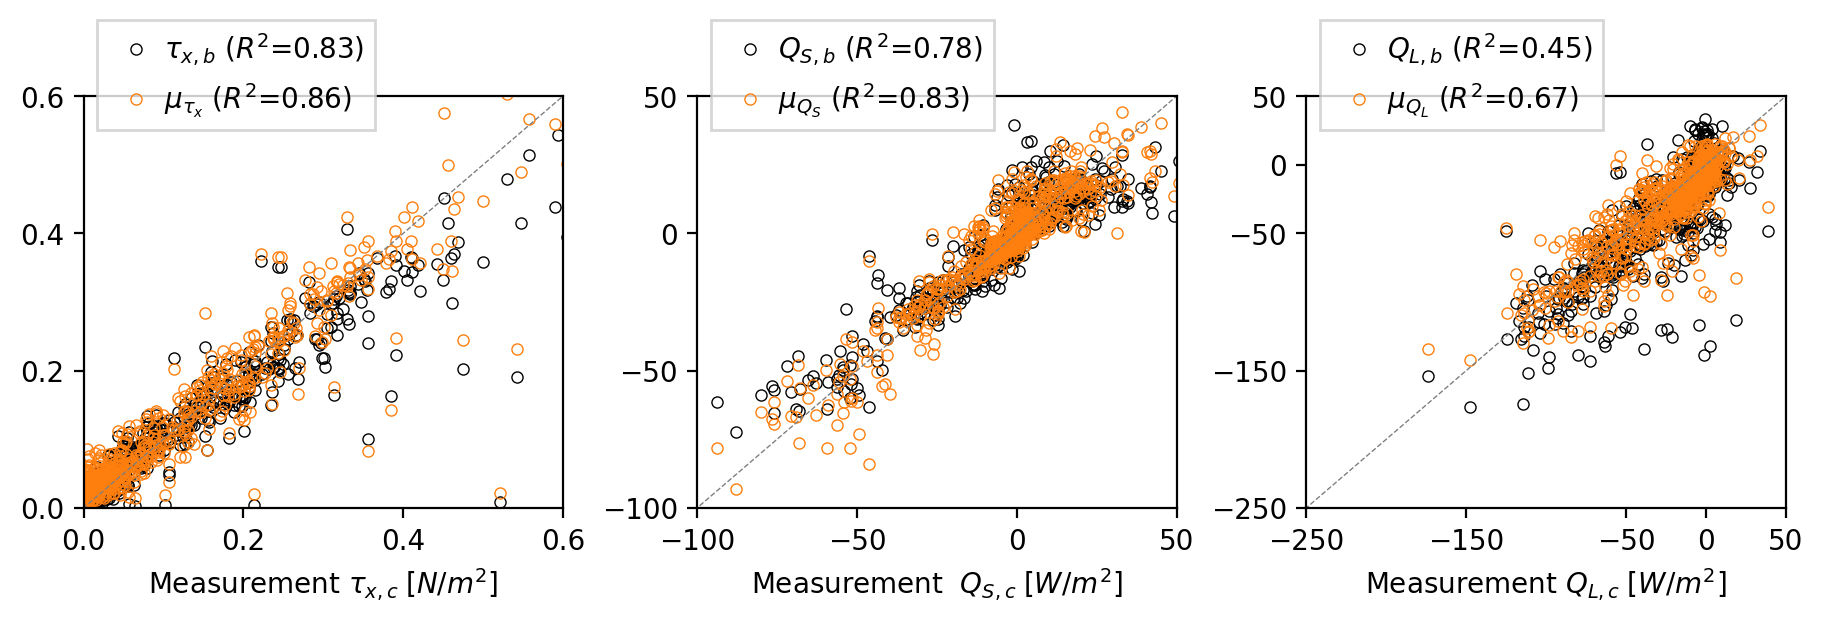

In [8]:
fig, axes = plt.subplots(1, 3, figsize=[9,3], dpi=200, constrained_layout=True)

ax = axes[0]; dir = M_dir
model = open_case (dir, 'model_rand%g.p' %rand_seed)
plot_corr (ax, model, testing_ds)

ax = axes[1]; dir = SH_dir
model = open_case (dir, 'model_rand%g.p' %rand_seed)
plot_corr (ax, model, testing_ds)

ax = axes[2]; dir = LH_dir
model = open_case (dir, 'model_rand%g.p' %rand_seed)
plot_corr (ax, model, testing_ds)

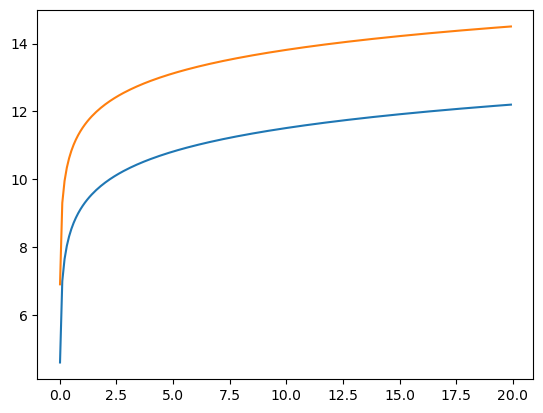

In [13]:
zarray = np.arange(0.01, 20, 0.1)
plt.plot(zarray, np.log(zarray/10**(-4)))
plt.plot(zarray, np.log(zarray/10**(-5)))

In [ ]:
''' First evaluate on the whole data set. '''
vd = RealFluxDataset(ds, input_keys=model.config['ikeys'], 
                     output_keys=model.config['okeys'], bulk_keys=model.config['bkeys'])
# [ann_mse, ann_r2, res_mean, res_var, wd, bulk_mse, bulk_r2]
scores = evaluate (model, ds, WEIGHT=model.config['WEIGHT'])

''' Then subsample for visualization. '''    
if subsample != None:        
    if model.config['WEIGHT']:
        w_index = np.random.choice(len(vd.X), subsample, p=vd.W.squeeze()/vd.W.sum())
    else:
        w_index = np.random.choice(len(vd.X), subsample)
    vd.X = vd.X[w_index,:]; vd.Y = vd.Y[w_index,:]; vd.Bulk = vd.Bulk[w_index,:]
    
Ypred_mean = model.pred_mean(vd.X)

cbulk = 'k'
cann = 'C1'
if model.config['okeys'] == ['hlc']:
    ax.set_ylim([-250,50]); ax.set_xlim([-250,50])
    ax.set_yticks([-250,-150,-50,0,50])
    ax.set_xticks([-250,-150,-50,0,50])
    ax.set_xlabel(r'Measurement $Q_{L,c} \; [W/m^2]$')
    # ax.set_ylabel(r'Prediction $[W/m^2]$')
    ax.plot(vd.Y, vd.Bulk, 'o', mfc="None", markeredgewidth=0.5, markersize=4, 
            label=r'$Q_{L,b}$ ($R^2$=%.2f)' %scores[-1], c=cbulk)
    ax.plot(vd.Y, Ypred_mean.detach().numpy(), 'o', mfc="None", markeredgewidth=0.5, markersize=4, 
            label=r'$\mu_{Q_L}$ ($R^2$=%.2f)' %scores[1], c=cann)

### R2 heatmap

Not weighted!
Not weighted!
Not weighted!
Not weighted!
Not weighted!


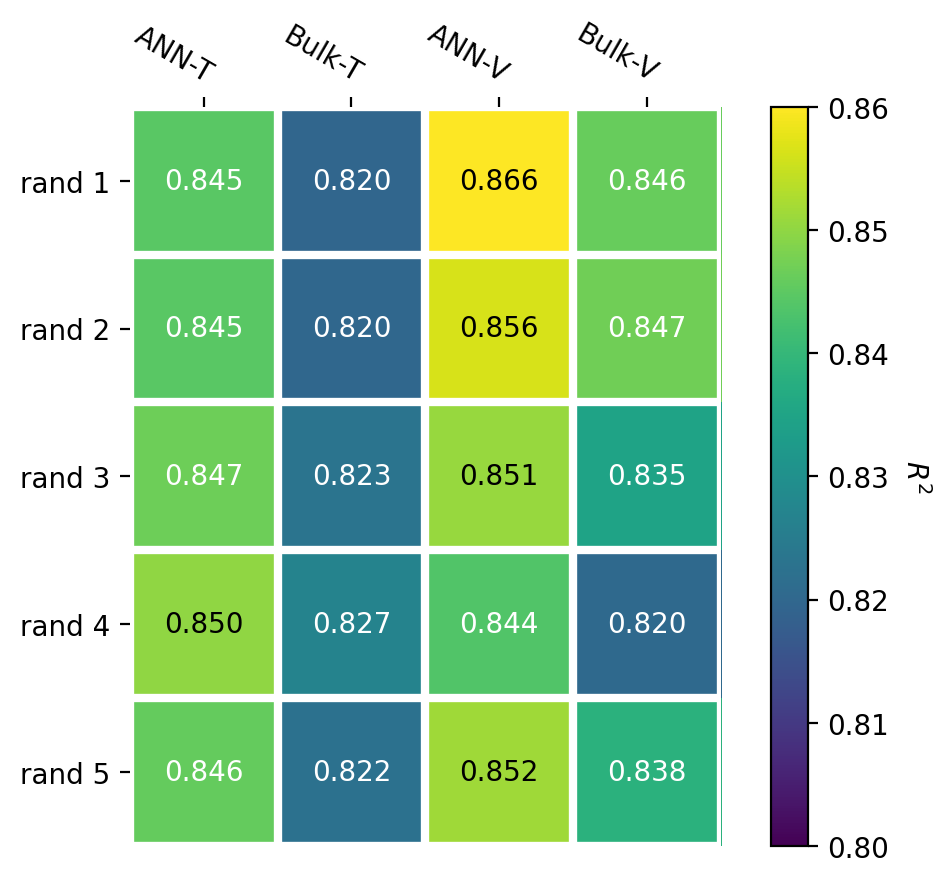

In [41]:
from mlflux.eval import heatmap, annotate_heatmap
from mlflux.datafunc import data_split_psd_rand

scores_rands = []
Nrand = 5

model_dir = M_dir
for rand_seed in range(Nrand):
    model_name = 'model_rand%g.p' %rand_seed
    model = open_case (model_dir, model_name)

    ds = xr.load_dataset(model.config['datapath'] + model.config['datafile'])
    training_ds, validating_ds, testing_ds = data_split_psd_rand(ds, seed=rand_seed, ratio=model.config['RATIO']) # validating and testing are the same        
    if model.config['WEIGHT']:
        # ann_mse, ann_r2, res_mean, res_var, wd, bulk_mse, bulk_r2
        print ('Weighted!')
        t_scores = evaluate (model, training_ds, WEIGHT=True)
        v_scores = evaluate (model, validating_ds, WEIGHT=True)
    else:
        print('Not weighted!')
        t_scores = evaluate (model, training_ds, WEIGHT=False) 
        v_scores = evaluate (model, validating_ds, WEIGHT=False)

        scores_rands.append(np.vstack([t_scores, v_scores])) # Nscores (14) * Nfeatures (1)

scores_rands = np.array(scores_rands).reshape(Nrand, -1)
corr = scores_rands [:,[1,6,8,13]]

row_labels = ['rand 1', 'rand 2', 'rand 3', 'rand 4','rand 5']
col_labels = ['ANN-T', 'Bulk-T', 'ANN-V', 'Bulk-V']

fig = plt.figure(dpi=200); ax = plt.gca()
# im, cbar = heatmap(corr, row_labels, col_labels, ax=ax, vmax=0.72, vmin=0.48, cbar_kw=None, cbarlabel=r"$R^2$")
# texts = annotate_heatmap(im, data=corr, valfmt="{x:.3f}", textcolors=("white", "black"), threshold=0.6);
# plt.savefig(f'../../plots/sup-r2-SH.png', bbox_inches='tight')
# im, cbar = heatmap(corr, row_labels, col_labels, ax=ax, vmax=0.7, vmin=0.5, cbar_kw=None, cbarlabel=r"$R^2$")
# texts = annotate_heatmap(im, data=corr, valfmt="{x:.3f}", textcolors=("white", "black"), threshold=0.6);
# plt.savefig(f'../../plots/sup-r2-LH.png', bbox_inches='tight')
im, cbar = heatmap(corr, row_labels, col_labels, ax=ax, vmax=0.86, vmin=0.8, cbar_kw=None, cbarlabel=r"$R^2$")
texts = annotate_heatmap(im, data=corr, valfmt="{x:.3f}", textcolors=("white", "black"), threshold=0.85);
plt.savefig(f'../../plots/sup-r2-M.png', bbox_inches='tight')

### R2 on subsets based on geophysical location

In [10]:
from mlflux.eval import evaluate_over_splits, evaluate_over_splits_alter, eval_bias_over_splits_alter

In [20]:
def compute_plot (ax, model): 
    ds = xr.load_dataset(model.config['datapath'] + model.config['datafile'])
    # scores: ann_mse, ann_r2, res_mean, res_var, wd, bulk_mse, bulk_r2
    scores = evaluate (model, ds, WEIGHT=False)
    nn_r2_splits, bulk_r2_splits, nn_mse_splits, bulk_mse_splits = evaluate_over_splits_alter (model, ds, WEIGHT=False)
    xplot = np.array([1,2,3,4])
    ax.plot(xplot, bulk_r2_splits, 'x', c='k')
    ax.plot(xplot, nn_r2_splits, 'x', c='C1')
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['Metz', 'N. Pac./Atl.', 'SO', 'Tropics'])

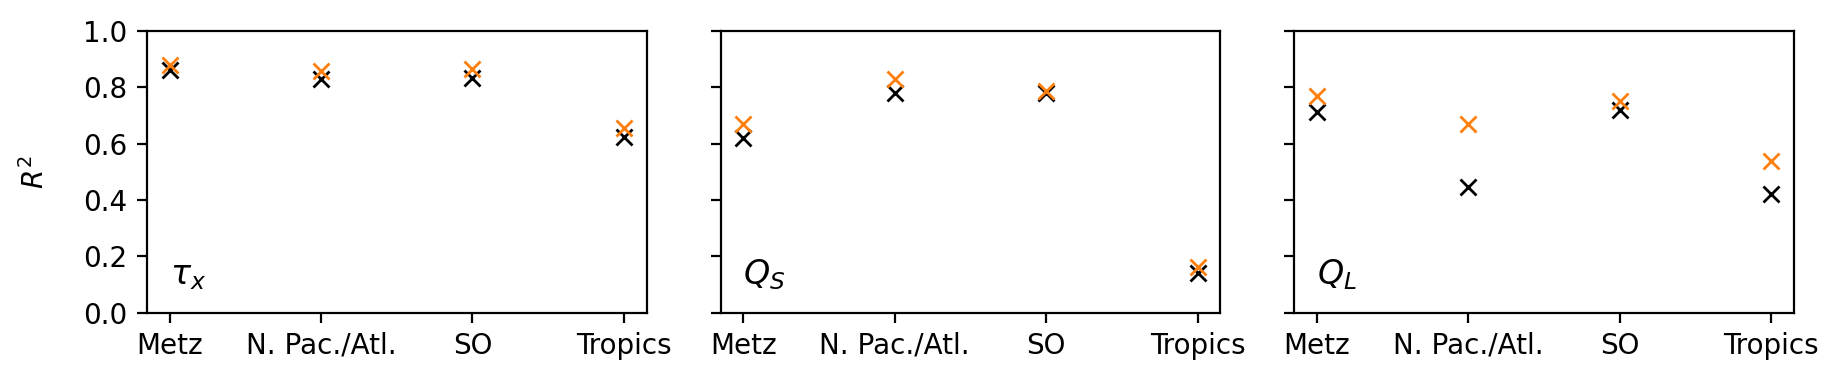

In [33]:
fig, axes = plt.subplots(1, 3, figsize=[9,2], dpi=200, sharey=True)
rand_seed = 4

model_dir = f'/scratch/jw8736/mlflux/saved_model/final/M5_1/NW_tr2/'
model_name = 'model_rand%g.p' %rand_seed
model = open_case (model_dir, model_name) 
compute_plot(axes[0], model)

model_dir = f'/scratch/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
model_name = 'model_rand%g.p' %rand_seed
model = open_case (model_dir, model_name) 
compute_plot(axes[1], model)

model_dir = f'/scratch/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'
model_name = 'model_rand%g.p' %rand_seed
model = open_case (model_dir, model_name) 
compute_plot(axes[2], model)

plt.ylim([0,1])
plt.tight_layout()
axes[0].set_ylabel('$R^2$', labelpad=12)
axes[0].text(1., 0.1, r"$\tau_x$", fontsize=12)
axes[1].text(1., 0.1, "$Q_S$", fontsize=12)
axes[2].text(1., 0.1, "$Q_L$", fontsize=12)
plt.savefig(f'../../plots/predictions_corr_split.png', bbox_inches='tight')

In [6]:
model_dir = f'/scratch/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'
model_dir = f'/scratch/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
model_dir = f'/scratch/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'

Nrand = 5
for rand_seed in range(Nrand):
    print('########### Rand ' + '%g' %rand_seed + ' ###########')
    model_name = 'model_rand%g.p' %rand_seed
    model = open_case (model_dir, model_name)     
    ds = xr.load_dataset(model.config['datapath'] + model.config['datafile'])
    # scores: ann_mse, ann_r2, res_mean, res_var, wd, bulk_mse, bulk_r2
    scores = evaluate (model, ds, WEIGHT=False)
    print('R2 full dataset: ANN - %.3f, bulk - %.3f' %(scores[1][0], scores[-1][0]))
    print('MSE full dataset: ANN - %.3f, bulk - %.3f' %(scores[0][0], scores[-2][0]))
    nn_r2_splits, bulk_r2_splits, nn_mse_splits, bulk_mse_splits = evaluate_over_splits (model, ds, WEIGHT=False)
    print('R2 [Metz, Mid-lat/SO, Tropics]:')
    print('ANN - [' + ', '.join(f'{num:.3f}' for num in nn_r2_splits), '], bulk - [' + ', '.join(f'{num:.3f}' for num in bulk_r2_splits) + ']')
    print('ANN - [' + ', '.join(f'{num:.3f}' for num in nn_mse_splits), '], bulk - [' + ', '.join(f'{num:.3f}' for num in bulk_mse_splits) + ']')

########### Rand 0 ###########
R2 full dataset: ANN - 0.680, bulk - 0.601
MSE full dataset: ANN - 926.111, bulk - 1152.917
R2 [Metz, Mid-lat/SO, Tropics]:
ANN - [0.766, 0.743, 0.538 ], bulk - [0.714, 0.682, 0.422]
ANN - [691.244, 590.879, 1116.652 ], bulk - [847.516, 730.579, 1398.051]
########### Rand 1 ###########
R2 full dataset: ANN - 0.674, bulk - 0.601
MSE full dataset: ANN - 942.589, bulk - 1152.917
R2 [Metz, Mid-lat/SO, Tropics]:
ANN - [0.760, 0.739, 0.532 ], bulk - [0.714, 0.682, 0.422]
ANN - [711.463, 598.645, 1132.883 ], bulk - [847.516, 730.579, 1398.051]
########### Rand 2 ###########
R2 full dataset: ANN - 0.687, bulk - 0.601
MSE full dataset: ANN - 906.016, bulk - 1152.917
R2 [Metz, Mid-lat/SO, Tropics]:
ANN - [0.765, 0.762, 0.550 ], bulk - [0.714, 0.682, 0.422]
ANN - [694.031, 547.409, 1089.251 ], bulk - [847.516, 730.579, 1398.051]
########### Rand 3 ###########
R2 full dataset: ANN - 0.683, bulk - 0.601
MSE full dataset: ANN - 916.676, bulk - 1152.917
R2 [Metz, Mid-la

In [5]:
model_dir = f'/scratch/jw8736/mlflux/saved_model/final/M5_1/NW_tr2/'
# model_dir = f'/scratch/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
# model_dir = f'/scratch/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'

rand_seed = 4
print('########### Rand ' + '%g' %rand_seed + ' ###########')
model_name = 'model_rand%g.p' %rand_seed
model = open_case (model_dir, model_name)     
ds = xr.load_dataset(model.config['datapath'] + model.config['datafile'])
# scores: ann_mse, ann_r2, res_mean, res_var, wd, bulk_mse, bulk_r2
scores = evaluate (model, ds, WEIGHT=False)
print('R2 full dataset: ANN - %.3f, bulk - %.3f' %(scores[1][0], scores[-1][0]))
print('MSE full dataset: ANN - %.3f, bulk - %.3f' %(scores[0][0], scores[-2][0]))
nn_r2_splits, bulk_r2_splits, nn_mse_splits, bulk_mse_splits = evaluate_over_splits (model, ds, WEIGHT=False)
print('R2 [Metz, Mid-lat/SO, Tropics]:')
print('ANN - [' + ', '.join(f'{num:.3f}' for num in nn_r2_splits), '], bulk - [' + ', '.join(f'{num:.3f}' for num in bulk_r2_splits) + ']')
print('ANN - [' + ', '.join(f'{num:.3f}' for num in nn_mse_splits), '], bulk - [' + ', '.join(f'{num:.3f}' for num in bulk_mse_splits) + ']')

########### Rand 4 ###########
R2 full dataset: ANN - 0.847, bulk - 0.825
MSE full dataset: ANN - 0.002, bulk - 0.002
R2 [Metz, Mid-lat/SO, Tropics]:
ANN - [0.878, 0.870, 0.655 ], bulk - [0.861, 0.842, 0.622]
ANN - [0.003, 0.003, 0.001 ], bulk - [0.003, 0.004, 0.001]


In [13]:
model_dir = f'/scratch/jw8736/mlflux/saved_model/final/M5_1/NW_tr2/'
model_dir = f'/scratch/jw8736/mlflux/saved_model/final/Mcross5_1/NW_tr2/'
model_dir = f'/scratch/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
model_dir = f'/scratch/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'

rand_seed = 4
print('########### Rand ' + '%g' %rand_seed + ' ###########')
model_name = 'model_rand%g.p' %rand_seed
model = open_case (model_dir, model_name)     
ds = xr.load_dataset(model.config['datapath'] + model.config['datafile'])
print(ds.sizes['time'])
# scores: ann_mse, ann_r2, res_mean, res_var, wd, bulk_mse, bulk_r2
scores = evaluate (model, ds, WEIGHT=False)
print('R2 full dataset: ANN - %.3f, bulk - %.3f' %(scores[1][0], scores[-1][0]))
print('RMSE full dataset: ANN - %.3f, bulk - %.3f' %(scores[0][0]**0.5, scores[-2][0]**0.5))
nn_r2_splits, bulk_r2_splits, nn_mse_splits, bulk_mse_splits = evaluate_over_splits_alter (model, ds, WEIGHT=False)
print('R2 [Metz, Mid-lat, SO, Tropics]:')
print('ANN - [' + ', '.join(f'{num:.5f}' for num in nn_r2_splits), '], bulk - [' + ', '.join(f'{num:.5f}' for num in bulk_r2_splits) + ']')
print('MSE [Metz, Mid-lat, SO, Tropics]:')
print('ANN - [' + ', '.join(f'{num**0.5:.5f}' for num in nn_mse_splits), '], bulk - [' + ', '.join(f'{num**0.5:.5f}' for num in bulk_mse_splits) + ']')

bias = eval_bias (model, ds, WEIGHT=False)
print('Bias full dataset: ANN - %.3f, bulk - %.3f' %(bias[0][0], bias[1][0]))
nn_bias_splits, bulk_bias_splits = eval_bias_over_splits_alter (model, ds, WEIGHT=False)
print('Bias [Metz, Mid-lat, SO, Tropics]:')
print('ANN - [' + ', '.join(f'{num:.3f}' for num in nn_bias_splits), '], bulk - [' + ', '.join(f'{num:.3f}' for num in bulk_bias_splits) + ']')

########### Rand 4 ###########
10079
R2 full dataset: ANN - 0.682, bulk - 0.601
RMSE full dataset: ANN - 30.339, bulk - 33.955
R2 [Metz, Mid-lat, SO, Tropics]:
ANN - [0.76822, 0.67119, 0.75287, 0.53799 ], bulk - [0.71362, 0.44710, 0.71873, 0.42205]
MSE [Metz, Mid-lat, SO, Tropics]:
ANN - [26.19074, 18.37373, 28.75082, 33.43033 ], bulk - [29.11214, 23.82572, 30.67282, 37.39052]
Bias full dataset: ANN - 0.255, bulk - -5.496
Bias [Metz, Mid-lat, SO, Tropics]:
ANN - [0.907, -4.607, 4.666, 0.079 ], bulk - [-8.239, -9.465, 4.538, -4.493]


### Plot normalized stochastic residual distribution

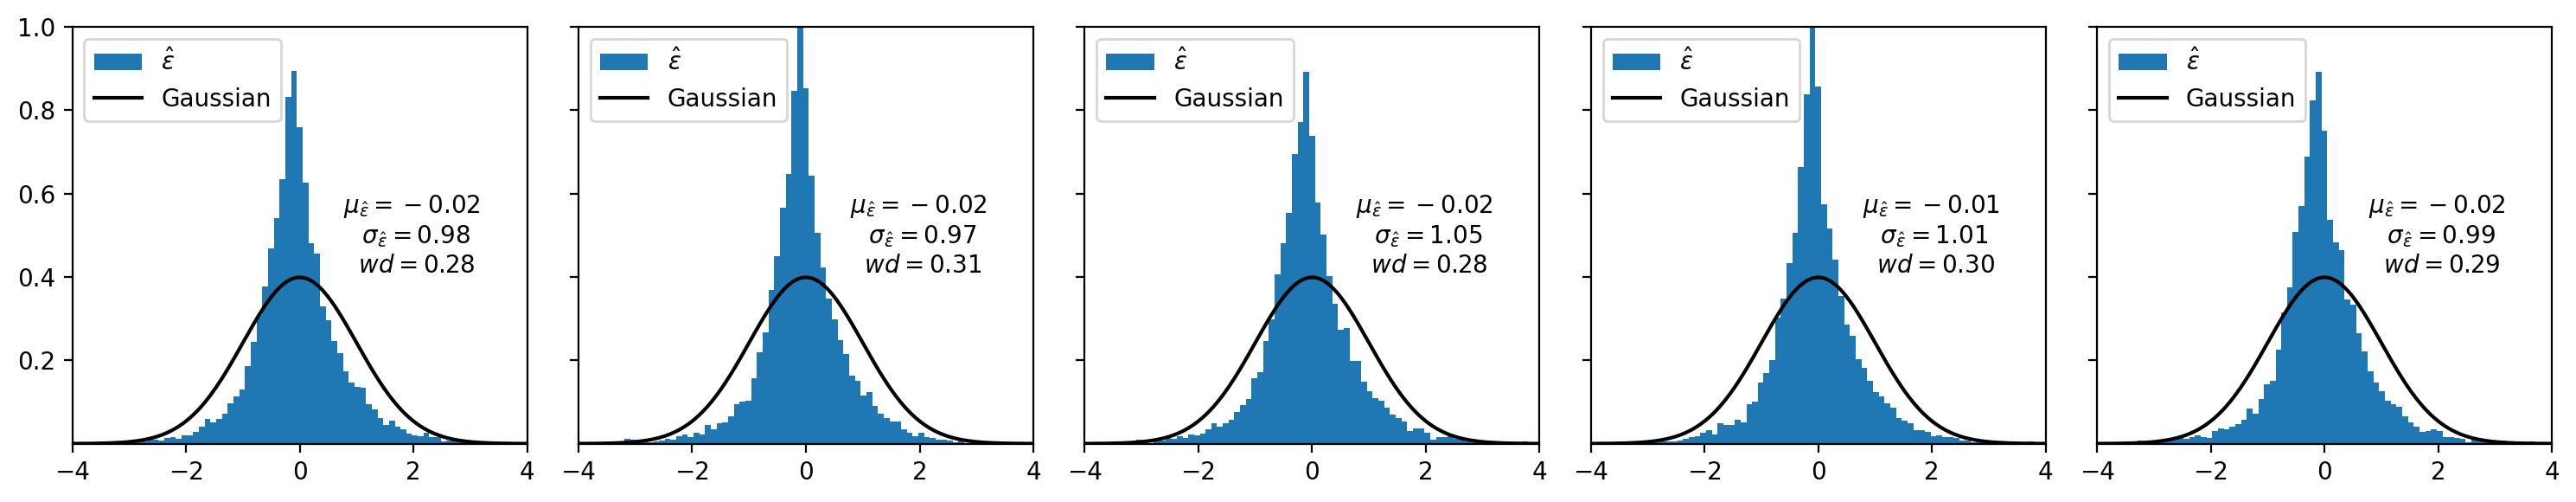

In [15]:
# model_dir = f'/home/jw8736/mlflux/saved_model/final/SH5_5/NW_tr5/'
# model_dir = f'/home/jw8736/mlflux/saved_model/final/SH5_5/tr5/'
# model_dir = f'/home/jw8736/mlflux/saved_model/final/SH8_1/NW_tr2/'
# model_dir = f'/home/jw8736/mlflux/saved_model/final/SH8_1/tr2/'
# model_dir = f'/home/jw8736/mlflux/saved_model/final/SH4_1/tr2/'
# model_dir = f'/home/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'

###### Used ones
model_dir = f'/home/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'


fig, axes = plt.subplots(1, 5, figsize=[15,3], dpi=200, sharey=True)
for rand_seed in range(5):
    model_name = 'model_rand%g.p' %rand_seed
    model = open_case (model_dir, model_name)
    ax = axes[rand_seed]
    ds = xr.load_dataset(model.config['datapath'] + model.config['datafile'])
    plot_res (ax, model, ds)
    
plt.tight_layout();

In [ ]:
# x = np.linspace(mu - 10*sigma, mu + 10*sigma, 1000)
# y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)
# plt.plot(x, y_, color='r', label='Cauchy')